In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from keras import models, layers, Model
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#1. Load Data

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/딥러닝과응용/jigsaw/train.csv')
print(data.shape)

(1804874, 45)


In [4]:
data.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


#2. Set index & target label


In [5]:
# 데이터에서 필요한 부분(문장, target값)만 추출
# 인덱스, 라벨 설정

data_df = data[['id','comment_text','target']]

# set index
data_df.set_index('id', inplace=True)

# y_label
data_df['label'] = np.where(data_df['target'] >= 0.5, 1, 0) # Label 1 >= 0.5 / Label 0 < 0.5

<ipython-input-5-53bef4792872>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['label'] = np.where(data_df['target'] >= 0.5, 1, 0) # Label 1 >= 0.5 / Label 0 < 0.5


In [6]:
data_df.head()

,comment_text,target,label
id,,,
59848,"This is so cool. It's like, 'would you want yo...",0.000000,0
59849,Thank you!! This would make my life a lot less...,0.000000,0
59852,This is such an urgent design problem; kudos t...,0.000000,0
59855,Is this something I'll be able to install on m...,0.000000,0
59856,haha you guys are a bunch of losers.,0.893617,1


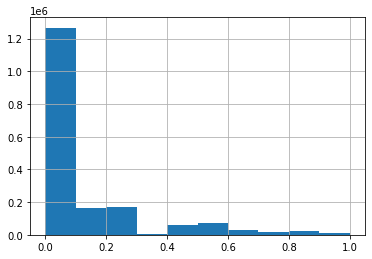

In [7]:
#target값 분포를 살펴보기
data_df['target'].hist()

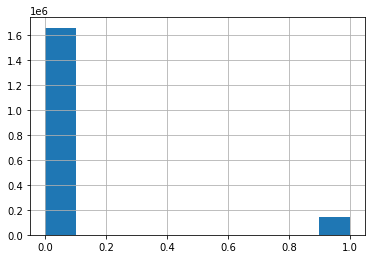

In [8]:
# label 분포를 살펴보기
data_df['label'].hist()

In [9]:
# 불균형 데이터
# 하지만 연속형 변수
# 방법 1 : 클러스터링 해서 다분류 문제로 치환
# 방법 2 : 특정 구간 처리해서 균일하게

print('전체 데이터 개수 :',len(data_df))
print('target값 0인  데이터 개수 :',len(data_df[(data_df['target'] ==0)]))

전체 데이터 개수 : 1804874
target값 0인  데이터 개수 : 1264764


In [10]:
# 방법 2 적용 
data_df=data_df[(data_df['target'] >0)] 

In [11]:
# 남은 데이터 개수
len(data_df)

540110

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe0b6b74700>,
      dtype=object)

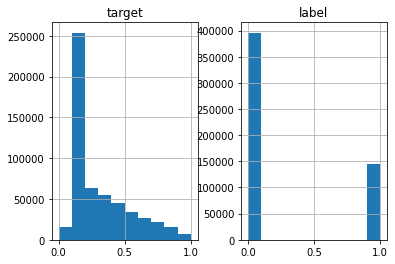

In [12]:
# 처음보다는 조금 균형
data_df.hist()

In [13]:
# 언더샘플링 이용해서 라벨링 불균형 문제 해소

# toxic nontoxic 분류
toxic = data_df[data_df['label']==1]
nontoxic = data_df[data_df['label']==0]

# nontoxic 에서 toxic 만큼 샘플링
nontoxic = nontoxic.sample(n=len(toxic),random_state =1018)

In [14]:
print(toxic.shape,nontoxic.shape)

(144334, 3) (144334, 3)


In [15]:
new_df = pd.concat([toxic,nontoxic],axis=0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe0b6abe580>,
      dtype=object)

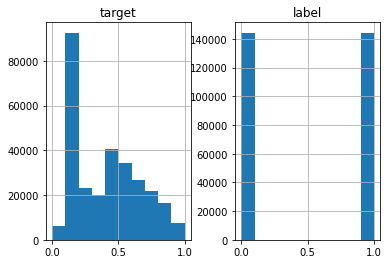

In [16]:
# 라벨의 불균형 문제는 해소
# target 값의 불균형 문제는 남아있을수도? (회귀모델이 데이터 셋에서 빈도가 높은 구간을 잘 예측하게 학습이 편향될 수 있으므로)
# 구간별로 샘플 개수 같게 하면 성능 향상? (추후 연구방향)
new_df.hist()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


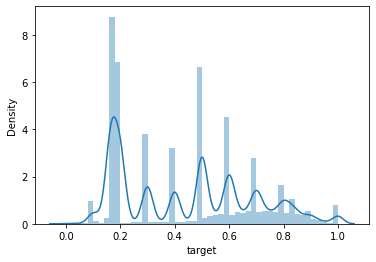

In [17]:
# target 값 분포 좀 더 자세히
sns.distplot(new_df['target'])

In [18]:
data_df=pd.concat([toxic,nontoxic],axis=0)

In [19]:
data_df=pd.concat([toxic,nontoxic],axis=0)

In [20]:
data_df = data_df.sort_index(ascending=True)

In [21]:
data_df

,comment_text,target,label
id,,,
59856,haha you guys are a bunch of losers.,0.893617,1
59859,ur a sh*tty comment.,0.666667,1
59861,hahahahahahahahhha suck it.,0.457627,0
239579,This is a great story. Man. I wonder if the pe...,0.440000,0
239583,It's ridiculous that these guys are being call...,0.600000,1
...,...,...,...
6333927,"I take your point, but I think you're shooting...",0.700000,1
6333928,My thought exactly. The only people he hasn't...,0.200000,0
6333950,"Nah, I am too boring to parody. This guy Camp...",0.200000,0


#3. View text data


In [22]:
data_df['comment_text'].head(20)

id
59856                  haha you guys are a bunch of losers.
59859                                  ur a sh*tty comment.
59861                           hahahahahahahahhha suck it.
239579    This is a great story. Man. I wonder if the pe...
239583    It's ridiculous that these guys are being call...
239584    This story gets more ridiculous by the hour! A...
239592    Angry trolls, misogynists and Racists", oh my....
239607    Yet call out all Muslims for the acts of a few...
239612    This bitch is nuts. Who would read a book by a...
239632    YET ANOTHER BARACK OBAMA LIBERAL MEDIA CONSPIR...
239637    Thank you, thank you, thank you! I love WW con...
239653    Mormons have had a complicated relationship wi...
239655                              Send more dildos, STAT.
239678    To anyone reading this article. That's me and ...
239696    Tuesday Jan. 13, members of \nthis socalled 'm...
239699    Tuesday Jan. 13, members of \nthis socalled 'm...
239731    Love that they also partici

#4. Remove Punctuation & Stopword

In [23]:
## Clean Punctuation & Stopwords
class clean_text:
	def __init__(self, text):
		self.text = text
	
	# Remove Punctuation
	def rm_punct(text):
		punct = set([p for p in "…/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'])
		text = [t for t in text if t not in punct]
			
		return "".join(text)

	# Remove Stopwords
	def rm_stopwords(text):
		word_tokens = word_tokenize(text)   
		result = [w for w in word_tokens if w not in stop_words]
				
		return " ".join(result)

In [24]:
# remove punctuation 
data_df['comment_text'] = data_df['comment_text'].apply(lambda x: clean_text.rm_punct(x))
#test_df['comment_text'] = test_df['comment_text'].apply(lambda x: clean_text.rm_punct(x))

# remove stopwords
data = data_df['comment_text'].apply(lambda x: clean_text.rm_stopwords(x))
#X_test = test_df['comment_text'].apply(lambda x: clean_text.rm_stopwords(x))

In [25]:
# 불용어 처리 결과 확인 (you는 불용어 처리가 되지만 You는 불용어 처리가 되지 않는다..
# 데이터셋을 무조건 소문자 처리 하는거는 문제가 생길수도 (US, us 다른 의미)
# 방법 1 -> stop_words의 모든 단어의 첫 글자만 대문자로 바꾼 단어를 stop_word에 추가? (추후 연구방향)
print('you' in stop_words)
print('You' in stop_words)

True
False


In [26]:
# 데이터 셋을 train set, validation set, test set 으로 분리
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(data, data_df['target'], test_size=0.2, random_state=1018)

In [28]:
# train set과 test set의 데이터 수
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(230934,) (57734,) (230934,) (57734,)


In [29]:
# 문장 뽑아서 봤더니 이모지가 포함되어 있는것 발견 ...
for i in range(1000):
  print(X_train[X_train.index[i]])

Why dont Weintraub investigate CNN incendiary blackmail charge citizens first amendment rights These Dem leftover deep state witch hunts must end Sessions need start waving big stick
I voted Wynn Trudeau Ive voting conservative 44 years I voted Wynn regret every day I couldnt get behind Tim Hudak For Hudak far right social conscious even little It wasnt vote vote So yeah I guess Im one stupid ones mentioned But defense Ill say OLeary much worse Hudak He doesnt represent conservative party Ill vote
cholo going taco bell cholo know name speaks volumes goes hollywood mexican fast food joint oye vato que pasa hermano
Was car unconscious half naked woman Islamic
usual lunatic lefty insult people facts debate attempted insults aa left void intelligence every turn news flash ignorant one even CBC corporate commodity guess want get rid cbc GREAT
Political bigot like Johann got lot common neoConfederates If really study Civil War ignorance clearly shows realized Alexander Stevens wrote white su

In [30]:
# 이모지 제거 함수 정의
import re

text_test = u'This dog \U0001f602'
print(text_test) # with emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
print(emoji_pattern.sub(r'', text_test)) # no emoji
print(emoji_pattern.findall(text_test))  # only emoji

This dog 😂
This dog 
['😂']


In [31]:
# train set에서 이모지 제거
for i in X_train.index:
  X_train[i] = emoji_pattern.sub(r'', X_train[i])
# test set에서 이모지 제거
for i in X_test.index:
  X_test[i] = emoji_pattern.sub(r'', X_test[i])

#5. Tokenize

In [32]:
## tokenize
# tokenize 할 때 단어 각각의 의미를 살리는 방법? (추후 연구 방향)
max_words = 100000
tokenizer = text.Tokenizer(num_words=max_words) # Tokenizer 객체생성
tokenizer.fit_on_texts(X_train)	# 토큰 별 word index 생성

# texts_to_sequences
sequences_text_train = tokenizer.texts_to_sequences(X_train)
sequences_text_test = tokenizer.texts_to_sequences(X_test)

print(sequences_text_train[:5])

[[88, 8, 33076, 3235, 1511, 17566, 8320, 847, 337, 71, 1102, 243, 322, 3058, 18934, 1124, 60, 2650, 10341, 119, 226, 1826, 36, 279, 5758, 153, 1385], [1, 298, 16509, 206, 300, 538, 395, 6983, 35, 1, 298, 16509, 5241, 62, 125, 1, 659, 9, 452, 5025, 15300, 286, 15300, 139, 20, 399, 7967, 18, 107, 15, 411, 116, 116, 47, 508, 1, 296, 48, 7, 44, 333, 1558, 41, 970, 319, 39, 2887, 34, 361, 15300, 26, 70, 1476, 395, 98, 319, 116], [15935, 37, 14285, 5026, 15935, 17, 244, 2095, 6389, 419, 2646, 2253, 1451, 717, 5640, 52481, 69380, 14751, 52482, 69381], [1569, 617, 9417, 589, 4027, 276, 836], [849, 1639, 2368, 1596, 3, 289, 1019, 2693, 2179, 5595, 73, 5350, 899, 62, 528, 114, 6191, 200, 7, 18, 2074, 961, 10233, 296, 28, 9, 860, 2074, 142]]


In [33]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [34]:
# 가장 긴 문장의 길이와 나머지 문장의 길이가 같아지게 0 패딩
max_len = max(len(l) for l in sequences_text_train)
pad_train = pad_sequences(sequences_text_train, maxlen=max_len)
pad_test = pad_sequences(sequences_text_test, maxlen=max_len)

print(pad_train[:5])

[[    0     0     0 ...  5758   153  1385]
 [    0     0     0 ...    98   319   116]
 [    0     0     0 ... 14751 52482 69381]
 [    0     0     0 ...  4027   276   836]
 [    0     0     0 ...   860  2074   142]]


#6. Embedding + LSTM model

In [35]:
# weighted sum 모델
def Embedding_CuDNNLSTM_model(max_words, max_len):
	
	sequence_input = layers.Input(shape=(None, ))
	x = layers.Embedding(max_words, 128, input_length=max_len)(sequence_input)
	x = layers.SpatialDropout1D(0.4)(x)
	x = layers.Bidirectional(layers.CuDNNLSTM(64, return_sequences=True))(x)
	x = layers.Bidirectional(layers.CuDNNLSTM(64, return_sequences=True))(x)
	
	avg_pool1d = layers.GlobalAveragePooling1D()(x)
	max_pool1d = layers.GlobalMaxPool1D()(x)
	x = layers.concatenate([avg_pool1d, max_pool1d])
	x = layers.Dense(32, activation='relu')(x)
	x = layers.BatchNormalization()(x)
	output = layers.Dense(1)(x)
 
	model = models.Model(sequence_input, output)
	
	return model

#embedding_lstm models 
model = Embedding_CuDNNLSTM_model(max_words, max_len)

# model compile
adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,
			 loss='mse')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 128)    12800000    ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, None, 128)   0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, None, 128)    99328       ['spatial_dropout1d[0][0]']  

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
# keras.callbacks
callbacks_list = [
		ReduceLROnPlateau(
			monitor='val_loss', patience=2, factor=0.1, mode='auto'),	# val_loss가 patience동안 향상되지 않으면 학습률을 0.1만큼 감소 (new_lr = lr * factor)
		EarlyStopping(
			patience=5, monitor='val_loss', mode='auto', restore_best_weights=True),
		ModelCheckpoint(
			filepath='/content/drive/MyDrive/Colab Notebooks/딥러닝과응용/jigsaw/best_bilstm_weightedsum.h5', monitor='val_loss', mode='auto', save_best_only=True)
]

# model fit & save
model_path = '/content/drive/MyDrive/Colab Notebooks/딥러닝과응용/jigsaw/best_embedding_weightedsum.h5'
if os.path.exists(model_path):
	model.load_weights(model_path)
else:
	history = model.fit(pad_train, Y_train,
						epochs=20, batch_size=256,
						callbacks=callbacks_list, 
						validation_split=0.3, verbose=1)

Epoch 1/20
632/632 [==============================] - 77s 109ms/step - loss: 0.1182 - val_loss: 0.0409 - lr: 1.0000e-04
Epoch 2/20
632/632 [==============================] - 68s 108ms/step - loss: 0.0356 - val_loss: 0.0304 - lr: 1.0000e-04
Epoch 3/20
632/632 [==============================] - 68s 108ms/step - loss: 0.0295 - val_loss: 0.0286 - lr: 1.0000e-04
Epoch 4/20
632/632 [==============================] - 67s 105ms/step - loss: 0.0264 - val_loss: 0.0373 - lr: 1.0000e-04
Epoch 5/20
632/632 [==============================] - 68s 108ms/step - loss: 0.0247 - val_loss: 0.0278 - lr: 1.0000e-04
Epoch 6/20
632/632 [==============================] - 66s 104ms/step - loss: 0.0234 - val_loss: 0.0333 - lr: 1.0000e-04
Epoch 7/20
632/632 [==============================] - 68s 107ms/step - loss: 0.0221 - val_loss: 0.0281 - lr: 1.0000e-04
Epoch 8/20
632/632 [==============================] - 66s 104ms/step - loss: 0.0203 - val_loss: 0.0280 - lr: 1.0000e-05
Epoch 9/20
632/632 [====================

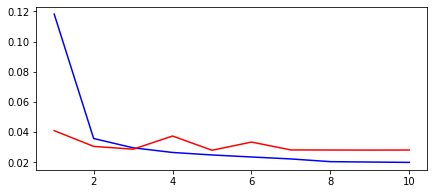

In [37]:
# plot score by epochs
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(7,3))
plt.plot(epochs, loss, 'b', label='loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')

In [38]:
## predict test_set
test_pred = model.predict(pad_test)

1805/1805 [==============================] - 39s 21ms/step


In [39]:
test_pred

array([[0.60547525],
       [0.37153617],
       [0.22998774],
       ...,
       [0.5453928 ],
       [0.31223753],
       [0.76032585]], dtype=float32)

In [40]:
Y_test

id
6005602    0.500000
5272300    0.400000
951176     0.300000
432924     0.775862
5446348    0.700000
             ...   
6109782    0.166667
504623     0.961538
5871724    0.626667
5239745    0.200000
306322     0.514286
Name: target, Length: 57734, dtype: float64

In [58]:
for i in range(100):
  r = round(Y_test[Y_test.index[i]],3)
  p = round(test_pred[i][0],3)
  r_s = str(i+1)+'번째 예측 target 값 :'+str(p)
  l_s = str(i+1)+'번째 실제 target 값 :'+str(r)
  print("{0:<40} {1:<30}".format(l_s,r_s))

1번째 실제 target 값 :0.5                     1번째 예측 target 값 :0.605        
2번째 실제 target 값 :0.4                     2번째 예측 target 값 :0.372        
3번째 실제 target 값 :0.3                     3번째 예측 target 값 :0.23         
4번째 실제 target 값 :0.776                   4번째 예측 target 값 :0.797        
5번째 실제 target 값 :0.7                     5번째 예측 target 값 :0.328        
6번째 실제 target 값 :0.109                   6번째 예측 target 값 :0.398        
7번째 실제 target 값 :0.92                    7번째 예측 target 값 :0.822        
8번째 실제 target 값 :0.3                     8번째 예측 target 값 :0.2          
9번째 실제 target 값 :0.3                     9번째 예측 target 값 :0.36         
10번째 실제 target 값 :0.2                    10번째 예측 target 값 :0.274       
11번째 실제 target 값 :0.605                  11번째 예측 target 값 :0.683       
12번째 실제 target 값 :0.167                  12번째 예측 target 값 :0.237       
13번째 실제 target 값 :0.5                    13번째 예측 target 값 :0.217       
14번째 실제 target 값 :1.0                    14번째 예측 target 값 :0.401

In [59]:
Y_test= pd.DataFrame(Y_test, columns=['target'])
Y_test

,target
id,
6005602,0.500000
5272300,0.400000
951176,0.300000
432924,0.775862
5446348,0.700000
...,...
6109782,0.166667
504623,0.961538
5871724,0.626667


In [60]:
Y_test['target']

id
6005602    0.500000
5272300    0.400000
951176     0.300000
432924     0.775862
5446348    0.700000
             ...   
6109782    0.166667
504623     0.961538
5871724    0.626667
5239745    0.200000
306322     0.514286
Name: target, Length: 57734, dtype: float64

In [61]:
Y_test_label = np.where(Y_test['target'] >= 0.5, 1, 0) # Label 1 >= 0.5 / Label 0 < 0.5
test_pred_label = np.where(test_pred>= 0.5, 1, test_pred)
test_pred_label = np.where(test_pred_label< 0.5, 0, test_pred_label)

In [62]:
Y_test_label

array([1, 0, 0, ..., 1, 0, 1])

In [63]:
test_pred_label

array([[1.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

In [64]:
from sklearn.metrics import roc_curve, roc_auc_score,f1_score
import numpy as np

In [65]:
y_test=Y_test['target'].values
y_test

array([0.5       , 0.4       , 0.3       , ..., 0.62666667, 0.2       ,
       0.51428571])

In [66]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(y_test, test_pred) 
MSE

0.02787340928591591

regression 모델로 학습했지만 classfication도 잘할까?

In [67]:
# 위에서 target 값이 0.5 이상이면 label을 1로, 0.5 미만이면 label을 0으로 설정했다
# 위에서 언더 샘플링으로 label의 불균형 문제를 해소
# 그렇게 한 이유? regression 모델 학습 잘해서 classification도 잘하라고
# 예측 target값 예측 label로 변환하여 auroc로 성능 평가

print(roc_auc_score(Y_test_label,test_pred))

0.8747779157587738


In [79]:
test_pred_label.shape

(57734, 1)

In [80]:
Y_pred_label = test_pred_label.reshape(-1)

In [81]:
Y_pred_label

array([1., 0., 0., ..., 1., 0., 1.], dtype=float32)

In [83]:
from sklearn.metrics import classification_report
target_names=['toxic','nontoxic']

print(classification_report(Y_test_label, Y_pred_label))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80     28890
           1       0.86      0.67      0.75     28844

    accuracy                           0.78     57734
   macro avg       0.79      0.78      0.78     57734
weighted avg       0.79      0.78      0.78     57734



#모델2 (output layer activation = sigmoid)
### output layer의 activation function을 weighted sum에서 sigmoid로 (예측값은 0~1 사이가 되어야 하기 때문)

In [147]:
def Embedding_CuDNNLSTM_model2(max_words, max_len):
	
	sequence_input = layers.Input(shape=(None, ))
	x = layers.Embedding(max_words, 128, input_length=max_len)(sequence_input)
	x = layers.SpatialDropout1D(0.4)(x)
	x = layers.Bidirectional(layers.CuDNNLSTM(64, return_sequences=True))(x)
	x = layers.Bidirectional(layers.CuDNNLSTM(64, return_sequences=True))(x)
	
	avg_pool1d = layers.GlobalAveragePooling1D()(x)
	max_pool1d = layers.GlobalMaxPool1D()(x)
	x = layers.concatenate([avg_pool1d, max_pool1d])
	x = layers.Dense(32, activation='relu')(x)
	x = layers.BatchNormalization()(x)
	output = layers.Dense(1, activation='sigmoid')(x)
 
	model = models.Model(sequence_input, output)
	
	return model

#embedding_lstm models 
model = Embedding_CuDNNLSTM_model2(max_words, max_len)

# model compile
adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,
			 loss='mse')

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, None, 128)    12800000    ['input_4[0][0]']                
                                                                                                  
 spatial_dropout1d_3 (SpatialDr  (None, None, 128)   0           ['embedding_3[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_6 (Bidirectional  (None, None, 128)   99328       ['spatial_dropout1d_3[0][0]

In [148]:
# keras.callbacks
callbacks_list = [
		ReduceLROnPlateau(
			monitor='val_loss', patience=2, factor=0.1, mode='auto'),	# val_loss가 patience동안 향상되지 않으면 학습률을 0.1만큼 감소 (new_lr = lr * factor)
		EarlyStopping(
			patience=5, monitor='val_loss', mode='auto', restore_best_weights=True),
		ModelCheckpoint(
			filepath='/content/drive/MyDrive/Colab Notebooks/딥러닝과응용/jigsaw/best_bilstm_sigmoid2.h5', monitor='val_loss', mode='auto', save_best_only=True)
]

# model fit & save
model_path = '/content/drive/MyDrive/Colab Notebooks/딥러닝과응용/jigsaw/best_bilstm__sigmoid2.h5'
if os.path.exists(model_path):
	model.load_weights(model_path)
else:
	history = model.fit(pad_train, Y_train,
						epochs=20, batch_size=256,
						callbacks=callbacks_list, 
						validation_split=0.3, verbose=1)

Epoch 1/20
632/632 [==============================] - 71s 108ms/step - loss: 0.0476 - val_loss: 0.0349 - lr: 1.0000e-04
Epoch 2/20
632/632 [==============================] - 67s 107ms/step - loss: 0.0303 - val_loss: 0.0294 - lr: 1.0000e-04
Epoch 3/20
632/632 [==============================] - 69s 108ms/step - loss: 0.0268 - val_loss: 0.0279 - lr: 1.0000e-04
Epoch 4/20
632/632 [==============================] - 66s 105ms/step - loss: 0.0249 - val_loss: 0.0279 - lr: 1.0000e-04
Epoch 5/20
632/632 [==============================] - 68s 107ms/step - loss: 0.0234 - val_loss: 0.0276 - lr: 1.0000e-04
Epoch 6/20
632/632 [==============================] - 66s 104ms/step - loss: 0.0223 - val_loss: 0.0278 - lr: 1.0000e-04
Epoch 7/20
632/632 [==============================] - 66s 105ms/step - loss: 0.0211 - val_loss: 0.0310 - lr: 1.0000e-04
Epoch 8/20
632/632 [==============================] - 66s 104ms/step - loss: 0.0193 - val_loss: 0.0283 - lr: 1.0000e-05
Epoch 9/20
632/632 [====================

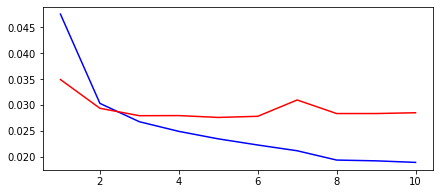

In [149]:
# plot score by epochs
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(7,3))
plt.plot(epochs, loss, 'b', label='loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')

In [150]:
## predict test_set
test_pred = model.predict(pad_test)

1805/1805 [==============================] - 36s 19ms/step


In [151]:
test_pred

array([[0.6065026 ],
       [0.39730796],
       [0.2223075 ],
       ...,
       [0.5293429 ],
       [0.31944418],
       [0.6810243 ]], dtype=float32)

In [152]:
Y_test

,target
id,
6005602,0.500000
5272300,0.400000
951176,0.300000
432924,0.775862
5446348,0.700000
...,...
6109782,0.166667
504623,0.961538
5871724,0.626667


In [153]:
for i in range(100):
  r = round(Y_test['target'][Y_test.index[i]],3)
  p = round(test_pred[i][0],3)
  r_s = str(i+1)+'번째 예측 target 값 :'+str(p)
  l_s = str(i+1)+'번째 실제 target 값 :'+str(r)
  print("{0:<40} {1:<30}".format(l_s,r_s))

1번째 실제 target 값 :0.5                     1번째 예측 target 값 :0.607        
2번째 실제 target 값 :0.4                     2번째 예측 target 값 :0.397        
3번째 실제 target 값 :0.3                     3번째 예측 target 값 :0.222        
4번째 실제 target 값 :0.776                   4번째 예측 target 값 :0.745        
5번째 실제 target 값 :0.7                     5번째 예측 target 값 :0.276        
6번째 실제 target 값 :0.109                   6번째 예측 target 값 :0.388        
7번째 실제 target 값 :0.92                    7번째 예측 target 값 :0.76         
8번째 실제 target 값 :0.3                     8번째 예측 target 값 :0.183        
9번째 실제 target 값 :0.3                     9번째 예측 target 값 :0.311        
10번째 실제 target 값 :0.2                    10번째 예측 target 값 :0.293       
11번째 실제 target 값 :0.605                  11번째 예측 target 값 :0.657       
12번째 실제 target 값 :0.167                  12번째 예측 target 값 :0.183       
13번째 실제 target 값 :0.5                    13번째 예측 target 값 :0.237       
14번째 실제 target 값 :1.0                    14번째 예측 target 값 :0.39 

In [154]:
Y_test= pd.DataFrame(Y_test, columns=['target'])
Y_test

,target
id,
6005602,0.500000
5272300,0.400000
951176,0.300000
432924,0.775862
5446348,0.700000
...,...
6109782,0.166667
504623,0.961538
5871724,0.626667


In [155]:
Y_test['target']

id
6005602    0.500000
5272300    0.400000
951176     0.300000
432924     0.775862
5446348    0.700000
             ...   
6109782    0.166667
504623     0.961538
5871724    0.626667
5239745    0.200000
306322     0.514286
Name: target, Length: 57734, dtype: float64

In [156]:
Y_test_label = np.where(Y_test['target'] >= 0.5, 1, 0) # Label 1 >= 0.5 / Label 0 < 0.5
test_pred_label = np.where(test_pred>= 0.5, 1, test_pred)
test_pred_label = np.where(test_pred_label< 0.5, 0, test_pred_label)

In [157]:
Y_test_label

array([1, 0, 0, ..., 1, 0, 1])

In [158]:
test_pred_label

array([[1.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

In [159]:
from sklearn.metrics import roc_curve, roc_auc_score,f1_score
import numpy as np

In [160]:
y_test=Y_test['target'].values
y_test

array([0.5       , 0.4       , 0.3       , ..., 0.62666667, 0.2       ,
       0.51428571])

In [161]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(y_test, test_pred) 
MSE

0.02745706205205122

regression 모델로 학습했지만 classfication도 잘할까?

In [162]:
# 위에서 target 값이 0.5 이상이면 label을 1로, 0.5 미만이면 label을 0으로 설정했다
# 위에서 언더 샘플링으로 label의 불균형 문제를 해소
# 그렇게 한 이유? regression 모델 학습 잘해서 classification도 잘하라고
# 예측 target값 예측 label로 변환하여 auroc로 성능 평가

print(roc_auc_score(Y_test_label,test_pred))

0.8751535593600774


In [163]:
test_pred_label.shape

(57734, 1)

In [164]:
Y_pred_label = test_pred_label.reshape(-1)

In [165]:
Y_pred_label

array([1., 0., 0., ..., 1., 0., 1.], dtype=float32)

In [166]:
from sklearn.metrics import classification_report
target_names=['toxic','nontoxic']

print(classification_report(Y_test_label, Y_pred_label))

              precision    recall  f1-score   support

           0       0.71      0.91      0.80     28890
           1       0.87      0.63      0.74     28844

    accuracy                           0.77     57734
   macro avg       0.79      0.77      0.77     57734
weighted avg       0.79      0.77      0.77     57734



# 두 모델 다 분류하지 못한 악성 문장들은 어떤 것들일까 ?

##### 위에서 출력한 100개의 실제 값과 예측 값 참고 
###### model1(weighted sum)의 경우
###### 5, 13, 14, 19, 21, 23, 29, 40, 42 ,46, 59, 70, 72, 74, 75, 94 번째 문장


In [167]:
model1_miss = [5,13,14,19,21,23,29,40,42,46,59,70,72,74,75,94]

In [168]:
#전처리 된 문장 추출
for i in model1_miss:
  print(i,"번째 문장")
  print(X_test[X_test.index[i]])

5 번째 문장
Voltaire must turning grave
13 번째 문장
Talk strawmen Do really think average sheriffs deputy policeman undertrained immature compared average CC civilian For shame
14 번째 문장
Trump adopted phrase America First old racist Nazi buzzword years ago It dogwhistle siren call white supremacist brethren Then Bannon spewed word salad Trump butcher attempt deny They came empty isolationism Trump immediately denied met Merkel Trump never foreign policy looking skim money wherever could Hes petty con man actual reasoned sane human hes fraud Hes imbalanced unfit office Now weak insecure belligerent child imagines fascist saviour Hes egotistical juvenile buffoon We need remove office get office Trump white supremacist Nazi sympathizer removed office
19 번째 문장
100 privileged young PC snowflakes get media attention 100 starving homeless veterans This exactly Trump elected The media public enema number one
21 번째 문장
Ok Ill take bait Heres guy boasts grabbing women genitals Theres nobody respect women

In [169]:
#원래 문장 추출
for i in model1_miss:
  print(i,"번째 문장")
  print(data_df['comment_text'][X_test.index[i]])

5 번째 문장
Voltaire must be turning in his grave
13 번째 문장
Talk about strawmen  Do you really think the average sheriffs deputy or policeman is undertrained and immature compared to the average CC civilian

For shame
14 번째 문장
Trump adopted the phrase America First because it was an old racist Nazi buzzword from years ago
It was a dogwhistle siren call to his white supremacist brethren
Then Bannon spewed out some word salad for Trump to further butcher in an attempt to deny it
They came up with the empty isolationism that Trump immediately denied when he met with Merkel
Trump never had any foreign policy other than looking to skim money wherever he could
Hes a petty con man not an actual reasoned or sane human being hes a fraud
Hes imbalanced unfit for office
Now we have a weak and insecure belligerent child who imagines himself a fascist saviour
Hes no more than an egotistical juvenile buffoon
We need to remove him from the office get him out of office now
Trump is a white supremacist Nazi

In [170]:
model2_miss = [5,13,14,21,23,29,40,42,46,54,59,66,70,72,74,75,90,94,97]

In [171]:
#전처리 된 문장 추출
for i in model2_miss:
  print(i,"번째 문장")
  print(X_test[X_test.index[i]])

5 번째 문장
Voltaire must turning grave
13 번째 문장
Talk strawmen Do really think average sheriffs deputy policeman undertrained immature compared average CC civilian For shame
14 번째 문장
Trump adopted phrase America First old racist Nazi buzzword years ago It dogwhistle siren call white supremacist brethren Then Bannon spewed word salad Trump butcher attempt deny They came empty isolationism Trump immediately denied met Merkel Trump never foreign policy looking skim money wherever could Hes petty con man actual reasoned sane human hes fraud Hes imbalanced unfit office Now weak insecure belligerent child imagines fascist saviour Hes egotistical juvenile buffoon We need remove office get office Trump white supremacist Nazi sympathizer removed office
21 번째 문장
Ok Ill take bait Heres guy boasts grabbing women genitals Theres nobody respect women I Is disputed interpretation strawman
23 번째 문장
No distract people wouldnt notice stupid sounds
29 번째 문장
Youre idiot It wasnt locker room talk Trump said He

In [172]:
#원래 문장 추출
for i in model2_miss:
  print(i,"번째 문장")
  print(data_df['comment_text'][X_test.index[i]])

5 번째 문장
Voltaire must be turning in his grave
13 번째 문장
Talk about strawmen  Do you really think the average sheriffs deputy or policeman is undertrained and immature compared to the average CC civilian

For shame
14 번째 문장
Trump adopted the phrase America First because it was an old racist Nazi buzzword from years ago
It was a dogwhistle siren call to his white supremacist brethren
Then Bannon spewed out some word salad for Trump to further butcher in an attempt to deny it
They came up with the empty isolationism that Trump immediately denied when he met with Merkel
Trump never had any foreign policy other than looking to skim money wherever he could
Hes a petty con man not an actual reasoned or sane human being hes a fraud
Hes imbalanced unfit for office
Now we have a weak and insecure belligerent child who imagines himself a fascist saviour
Hes no more than an egotistical juvenile buffoon
We need to remove him from the office get him out of office now
Trump is a white supremacist Nazi

In [173]:
len(model1_miss)

16

In [174]:
len(model2_miss)

19

In [176]:
models_miss = set(model1_miss)&set(model2_miss)

In [178]:
models_miss

{5, 13, 14, 21, 23, 29, 40, 42, 46, 59, 70, 72, 74, 75, 94}

In [179]:
len(models_miss)

15

In [180]:
#원래 문장 추출
for i in models_miss:
  print(i,"번째 문장")
  print(data_df['comment_text'][X_test.index[i]])

5 번째 문장
Voltaire must be turning in his grave
70 번째 문장
The POTUS doesnt read

As for all the options its his job to come up with the options not mine

Hes the POTUS not me

So far hes produced zero options
40 번째 문장
Sorry but your concerns sound very pretty much like the talking points repeated during the campaign Just using common sense as a filter it s clear OCare needs fixing
That was one point both Hillary and Trump agreed on Surprising it needs major fixes Not at all when you consider the ACA Law is some 1800 pages long and has 20000 pages of regulations Why when the new administration states numerous times  the need is to improve the ACA and that is in process To repeal and replace it with an improved plan that will be seamless so those who have coverage will continue to be covered Yet many people and the press coverage suggests ACA coverage will be taken away or be lesser under the new administration That would be political suicide and I am confident they will avoid that  they ju